In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = depthwiseseparableconv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_2 = depthwiseseparableconv2DBatchNormRelu(
            16, 32, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_3 = depthwiseseparableconv2DBatchNormRelu(
            32, 64, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv = nn.Conv2d(64, 3, 3, stride = 1)
        self.flatten = nn.Flatten()     
        self.sigmoid = nn.Sigmoid()
        self.global_avg = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.maxpool2d(self.cbr_2(x))
        x = self.maxpool2d(self.cbr_3(x))
        
        #全結合層
        x = self.flatten(self.global_avg(self.sigmoid(self.conv(x))))
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                             Output Shape              Param #
Model                                              [64, 3]                   --
├─depthwiseseparableconv2DBatchNormRelu: 1-1       [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                                 [64, 3, 32, 32]           84
│    └─BatchNorm2d: 2-2                            [64, 3, 32, 32]           6
│    └─ReLU: 2-3                                   [64, 3, 32, 32]           --
│    └─Conv2d: 2-4                                 [64, 16, 32, 32]          64
│    └─BatchNorm2d: 2-5                            [64, 16, 32, 32]          32
│    └─ReLU: 2-6                                   [64, 16, 32, 32]          --
│    └─Dropout2d: 2-7                              [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                                   [64, 16, 16, 16]          --
├─depthwiseseparableconv2DBatchNormRelu: 1-3       [64, 32, 16, 16]          --
│    └─Conv2d: 2-8                  

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=50
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.44it/s]


val Loss: 1.0986 Acc: 0.3333
Epoch 2/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 1.0860 Acc: 0.3894


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.09it/s]


val Loss: 1.1146 Acc: 0.3333
Epoch 3/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.56it/s]


train Loss: 1.0230 Acc: 0.4875


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.06it/s]


val Loss: 1.0801 Acc: 0.3943
Epoch 4/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.9746 Acc: 0.5656


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.51it/s]


val Loss: 1.0431 Acc: 0.4571
Epoch 5/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.53it/s]


train Loss: 0.9434 Acc: 0.6056


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.42it/s]


val Loss: 0.8947 Acc: 0.6419
Epoch 6/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.12it/s]


train Loss: 0.9318 Acc: 0.5976


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.41it/s]


val Loss: 0.9344 Acc: 0.6043
Epoch 7/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.80it/s]


train Loss: 0.9204 Acc: 0.6166


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.21it/s]


val Loss: 0.8815 Acc: 0.6695
Epoch 8/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


train Loss: 0.9019 Acc: 0.6306


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.63it/s]


val Loss: 0.8696 Acc: 0.6929
Epoch 9/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.66it/s]


train Loss: 0.8944 Acc: 0.6396


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.98it/s]


val Loss: 0.8865 Acc: 0.6557
Epoch 10/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


train Loss: 0.8821 Acc: 0.6577


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.92it/s]


val Loss: 0.8721 Acc: 0.6776
Epoch 11/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.67it/s]


train Loss: 0.8754 Acc: 0.6737


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.91it/s]


val Loss: 0.9575 Acc: 0.5738
Epoch 12/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.53it/s]


train Loss: 0.8633 Acc: 0.6847


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.07it/s]


val Loss: 0.8537 Acc: 0.6905
Epoch 13/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.57it/s]


train Loss: 0.8532 Acc: 0.6947


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.29it/s]


val Loss: 0.8424 Acc: 0.7086
Epoch 14/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


train Loss: 0.8618 Acc: 0.6777


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.27it/s]


val Loss: 0.8919 Acc: 0.6533
Epoch 15/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.8466 Acc: 0.6897


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.23it/s]


val Loss: 0.8480 Acc: 0.7067
Epoch 16/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.8491 Acc: 0.6937


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.25it/s]


val Loss: 0.8363 Acc: 0.7267
Epoch 17/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.8357 Acc: 0.7197


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.53it/s]


val Loss: 0.8362 Acc: 0.7157
Epoch 18/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.8443 Acc: 0.6877


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.09it/s]


val Loss: 0.8526 Acc: 0.6986
Epoch 19/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.68it/s]


train Loss: 0.8242 Acc: 0.7177


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.70it/s]


val Loss: 0.8315 Acc: 0.7314
Epoch 20/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.91it/s]


train Loss: 0.8306 Acc: 0.7217


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.58it/s]


val Loss: 0.8431 Acc: 0.7081
Epoch 21/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.89it/s]


train Loss: 0.8113 Acc: 0.7447


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.58it/s]


val Loss: 0.8379 Acc: 0.7081
Epoch 22/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.8184 Acc: 0.7227


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.60it/s]


val Loss: 0.8399 Acc: 0.6981
Epoch 23/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.89it/s]


train Loss: 0.8131 Acc: 0.7357


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.60it/s]


val Loss: 0.8239 Acc: 0.7262
Epoch 24/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.8082 Acc: 0.7257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.42it/s]


val Loss: 0.8230 Acc: 0.7200
Epoch 25/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.76it/s]


train Loss: 0.7974 Acc: 0.7477


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.19it/s]


val Loss: 0.8592 Acc: 0.6890
Epoch 26/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.81it/s]


train Loss: 0.7910 Acc: 0.7548


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.31it/s]


val Loss: 0.8336 Acc: 0.7262
Epoch 27/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.85it/s]


train Loss: 0.8101 Acc: 0.7317


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.30it/s]


val Loss: 0.8236 Acc: 0.7243
Epoch 28/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.8078 Acc: 0.7397


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.35it/s]


val Loss: 0.8167 Acc: 0.7305
Epoch 29/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.7838 Acc: 0.7778


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.48it/s]


val Loss: 0.8343 Acc: 0.7129
Epoch 30/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.43it/s]


train Loss: 0.7977 Acc: 0.7588


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.33it/s]


val Loss: 0.8069 Acc: 0.7414
Epoch 31/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


train Loss: 0.7901 Acc: 0.7618


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.56it/s]


val Loss: 0.8091 Acc: 0.7410
Epoch 32/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.89it/s]


train Loss: 0.7767 Acc: 0.7718


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.76it/s]


val Loss: 0.8146 Acc: 0.7157
Epoch 33/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.8000 Acc: 0.7548


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.80it/s]


val Loss: 0.8014 Acc: 0.7395
Epoch 34/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.7846 Acc: 0.7668


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.79it/s]


val Loss: 0.8438 Acc: 0.6971
Epoch 35/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.7811 Acc: 0.7788


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.77it/s]


val Loss: 0.7914 Acc: 0.7510
Epoch 36/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.91it/s]


train Loss: 0.7769 Acc: 0.7748


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.71it/s]


val Loss: 0.8641 Acc: 0.6643
Epoch 37/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.7732 Acc: 0.7828


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.74it/s]


val Loss: 0.8361 Acc: 0.7090
Epoch 38/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.7725 Acc: 0.7768


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.77it/s]


val Loss: 0.8048 Acc: 0.7395
Epoch 39/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.7692 Acc: 0.7848


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.80it/s]


val Loss: 0.8078 Acc: 0.7386
Epoch 40/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.7698 Acc: 0.7838


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.78it/s]


val Loss: 0.8018 Acc: 0.7476
Epoch 41/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.7697 Acc: 0.7798


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.77it/s]


val Loss: 0.8332 Acc: 0.7086
Epoch 42/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.89it/s]


train Loss: 0.7641 Acc: 0.7938


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.72it/s]


val Loss: 0.8032 Acc: 0.7500
Epoch 43/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.7638 Acc: 0.7858


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.79it/s]


val Loss: 0.7791 Acc: 0.7624
Epoch 44/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.83it/s]


train Loss: 0.7641 Acc: 0.7908


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.50it/s]


val Loss: 0.8102 Acc: 0.7295
Epoch 45/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.78it/s]


train Loss: 0.7541 Acc: 0.7918


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:14<00:00,  2.28it/s]


val Loss: 0.7820 Acc: 0.7748
Epoch 46/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.16it/s]


train Loss: 0.7537 Acc: 0.7998


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.57it/s]


val Loss: 0.7958 Acc: 0.7581
Epoch 47/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


train Loss: 0.7518 Acc: 0.8128


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.04it/s]


val Loss: 0.7892 Acc: 0.7552
Epoch 48/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


train Loss: 0.7520 Acc: 0.8098


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.80it/s]


val Loss: 0.8166 Acc: 0.7338
Epoch 49/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


train Loss: 0.7488 Acc: 0.8158


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.74it/s]


val Loss: 0.7769 Acc: 0.7738
Epoch 50/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.91it/s]


train Loss: 0.7482 Acc: 0.8018


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.78it/s]

val Loss: 0.8550 Acc: 0.6776


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

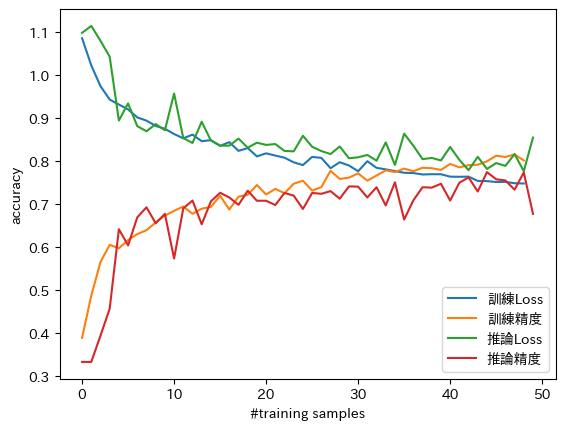

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

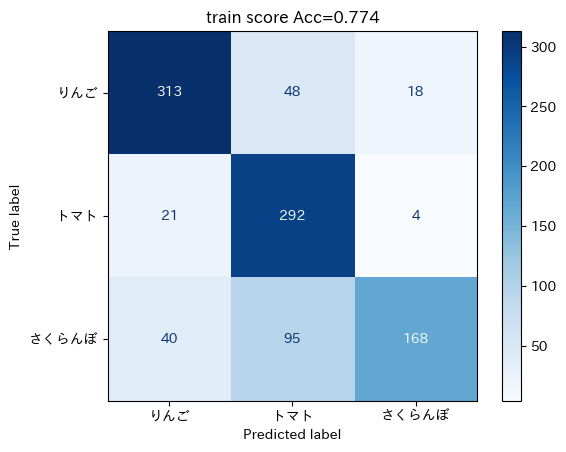

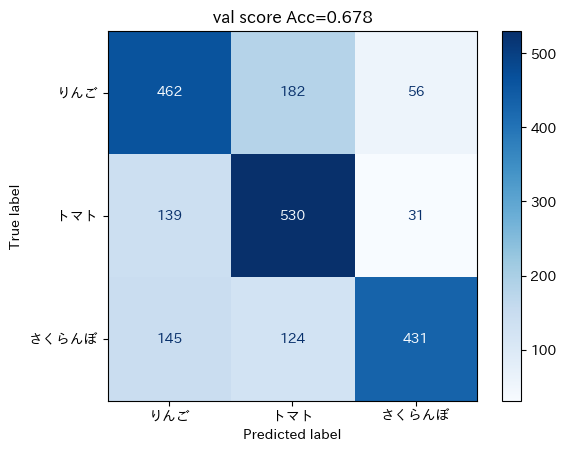

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

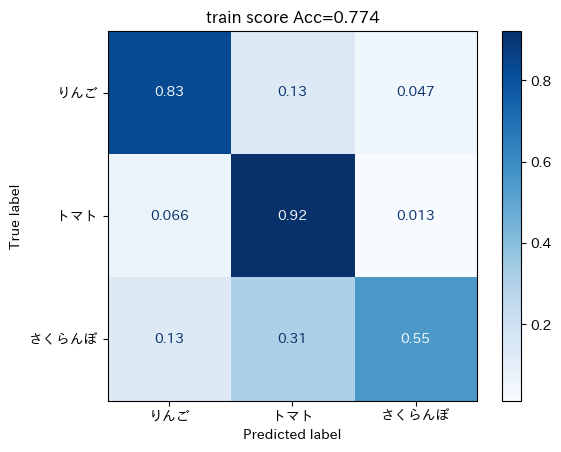

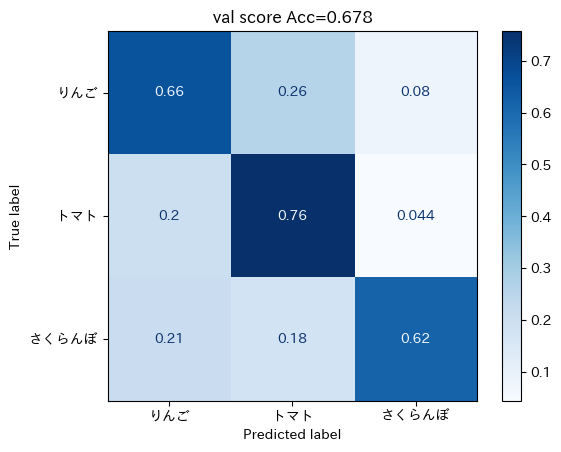

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()